c:\Users\HP\AppData\Local\Programs\Python\Python313\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Training Set Size: (941, 16)
Testing Set Size: (236, 16)
Applied SMOTE Oversampling. New Training Set Size: (1470, 16)
Applied Random UnderSampling. New Training Set Size: (1470, 16)
Model Accuracy: 0.95
Classification Report:
               precision    recall  f1-score   support

           0       0.98      0.98      0.98        52
           1       0.88      0.94      0.91        52
           2       0.97      0.97      0.97        36
           3       1.00      0.80      0.89         5
           4       1.00      1.00      1.00        12
           5       0.95      0.91      0.93        45
           6       1.00      0.97      0.99        34

    accuracy                           0.95       236
   macro avg       0.97      0.94      0.95       236
weighted avg       0.96      0.95      0.95       236



<Figure size 640x480 with 0 Axes>

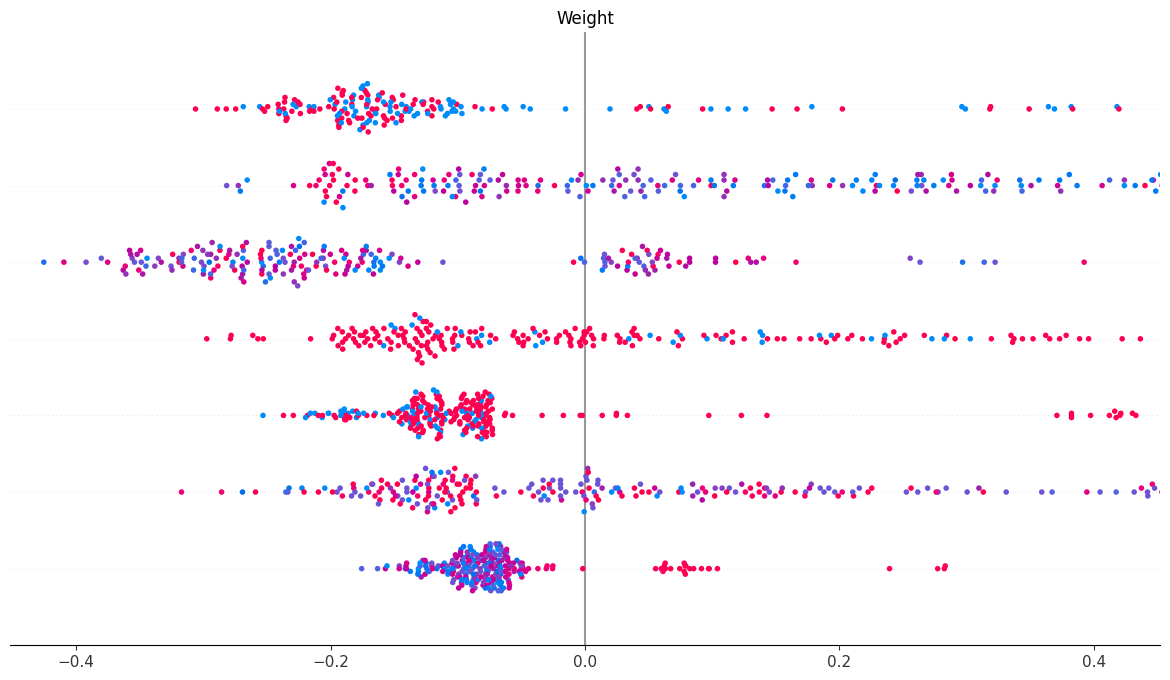

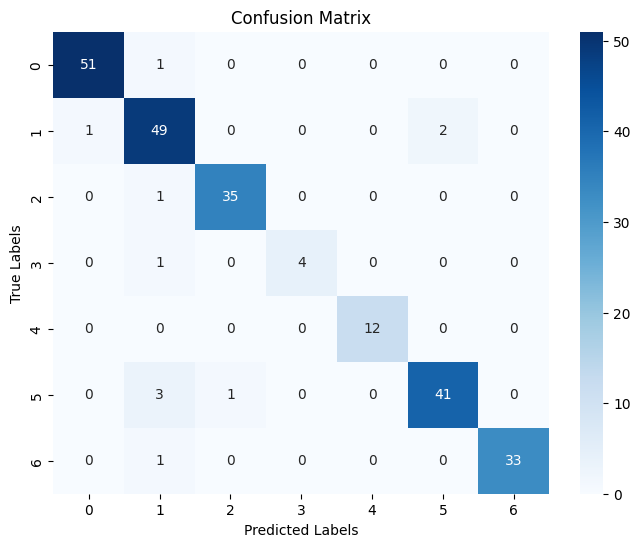

ROC-AUC Score For Random Forest: 0.9985


In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.utils.class_weight import compute_class_weight
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import label_binarize
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.combine import SMOTEENN
import shap


df = pd.read_csv(r"C:\Users\HP\Documents\GitHub\Coding-week-test\data\age_and_weight_cleaned.csv")





categorical_columns = ["Gender", "family_history_with_overweight", "NObeyesdad","FAVC","SMOKE","CAEC","SCC","CALC","MTRANS",]

##########spliting data###############
# Apply Label Encoding
label_encoders = {}
for col in categorical_columns:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])
    label_encoders[col] = le  # Save encoders if you need to inverse transform later

# Split into features (X) and target (y)
X = df.drop("NObeyesdad", axis=1)  # Features
y = df["NObeyesdad"]  # Target (Obesity Level)



# Split into 80% Training and 20% Testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print("Training Set Size:", X_train.shape)
print("Testing Set Size:", X_test.shape)


# ==== FLAGS FOR SAMPLING METHODS ====
USE_SMOTE = True           # Enable/Disable Oversampling
USE_UNDERSAMPLING = True  # Enable/Disable Undersampling
USE_CLASS_WEIGHTS = False  # Set this to True to use class weighting


# Apply Oversampling (SMOTE)
if USE_SMOTE:
    smote = SMOTE(sampling_strategy="auto", random_state=42)  # 60% oversampling
    X_train, y_train = smote.fit_resample(X_train, y_train)
    print("Applied SMOTE Oversampling. New Training Set Size:", X_train.shape)

# Apply Undersampling (RandomUnderSampler)
if USE_UNDERSAMPLING:
    undersample = RandomUnderSampler(sampling_strategy="auto", random_state=42)  # 80% of majority class
    X_train, y_train = undersample.fit_resample(X_train, y_train)
    print("Applied Random UnderSampling. New Training Set Size:", X_train.shape)

# Compute Class Weights (If Selected)
class_weight_dict = None
if USE_CLASS_WEIGHTS:
    class_weights = compute_class_weight(class_weight="balanced", 
                                         classes=np.unique(y_train), y=y_train)
    class_weight_dict = {cls: weight for cls, weight in zip(np.unique(y_train), class_weights)}
    print("Applied Class Weights:", class_weight_dict)


##################training#############

# Initialize Model with Selected Class Weights
model = RandomForestClassifier(n_estimators=100, random_state=42, 
                               class_weight=class_weight_dict if USE_CLASS_WEIGHTS else "balanced")


# Train Model
model.fit(X_train, y_train)

# Make Predictions
y_pred = model.predict(X_test)



#evaluation

# Check Accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Model Accuracy: {accuracy:.2f}")

# Detailed Performance Report
print("Classification Report:\n", classification_report(y_test, y_pred))

#explaination


explainer = shap.TreeExplainer(model)  # Use TreeExplainer for tree models
shap_values = explainer.shap_values(X_test)  # Ensure X_test matches training format

# Visualize Feature Importance
shap.summary_plot(shap_values, X_test)

# Compute the confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plot the heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap="Blues", xticklabels=set(y_test), yticklabels=set(y_test))
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")
plt.show()



# Binarize the labels for multi-class ROC-AUC
y_test_binarized = label_binarize(y_test, classes=[0, 1, 2, 3, 4, 5, 6])

# Compute ROC-AUC Score
roc_auc = roc_auc_score(y_test_binarized, model.predict_proba(X_test), multi_class="ovr")

print(f"ROC-AUC Score For Random Forest: {roc_auc:.4f}")